by Hugo Centeno Sanz | AISC Madrid

100498982@alumnos.ucm3.es

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Conceptos fundamentales

In [2]:
# Data
data = np.array([[0, 0], [0.1, 0], [0.2, 0], [0.5, 1], [0.6, 1], [0.7, 1], [0.8, 0], [0.9, 0], [1, 0]])
df = pd.DataFrame(data, columns=['Amount taken (g)', '% Effectiveness'])
df

,Amount taken (g),% Effectiveness
0,0.0,0.0
1,0.1,0.0
2,0.2,0.0
3,0.5,1.0
4,0.6,1.0
5,0.7,1.0
6,0.8,0.0
7,0.9,0.0
8,1.0,0.0


In [3]:
def relu(x):
    return np.maximum(0, x)

In [4]:
# Representation of our simple NN

# Upper path (green)
g_1 = 1.43 * df["Amount taken (g)"] - 0.61
t_1 = relu(g_1) * (-3.89)

# Lower path (red)
g_2 = 2.63 * df["Amount taken (g)"] - 0.27
t_2 = relu(g_2) * 1.35

# Network output
t = t_1 + t_2
upper_nn = np.array(list(zip(df["Amount taken (g)"], t_1)))
lower_nn = np.array(list(zip(df["Amount taken (g)"], t_2)))
whole_nn = np.array(list(zip(df["Amount taken (g)"], t)))

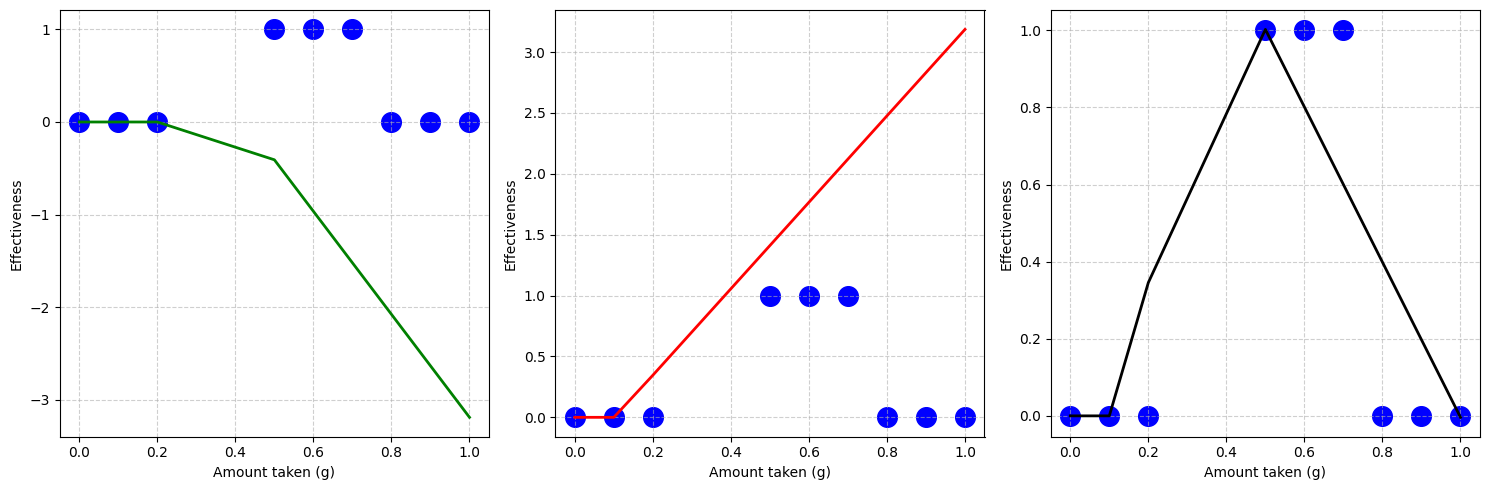

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Green path (upper)
axs[0].scatter(data[:,0], data[:,1], c="blue", marker="o", s=200)
axs[0].plot(upper_nn[:,0], upper_nn[:,1], c="green", linestyle="-", linewidth=2)
axs[0].set_xlabel("Amount taken (g)")
axs[0].set_ylabel("Effectiveness")
axs[0].grid(True, linestyle="--", alpha=0.6)

# Red path (lower)
axs[1].scatter(data[:,0], data[:,1], c="blue", marker="o", s=200)
axs[1].plot(lower_nn[:,0], lower_nn[:,1], c="red", linestyle="-", linewidth=2)
axs[1].set_xlabel("Amount taken (g)")
axs[1].set_ylabel("Effectiveness")
axs[1].grid(True, linestyle="--", alpha=0.6)

# Sum
axs[2].scatter(data[:,0], data[:,1], c="blue", marker="o", s=200)
axs[2].plot(df["Amount taken (g)"], t, c="black", linewidth=2)
axs[2].set_xlabel("Amount taken (g)")
axs[2].set_ylabel("Effectiveness")
axs[2].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


## Optimización simngle weights & bias con Gradient Descent


Sin PyTorch

In [8]:
learning_rate = 0.01
n_steps = 1000
w3 = 0.0

In [9]:
for step in range(n_steps):

    # Forward pass
    dSSRdW3_value = 0
    # Upper path
    g_1 = 1.43 * df["Amount taken (g)"] - 0.61
    t_1 = relu(g_1) * w3

    # Lower path
    g_2 = 2.63 * df["Amount taken (g)"] - 0.27
    t_2 = relu(g_2) * 1.35

    # Network output
    t = t_1 + t_2

    #Backpropagation

    # Compute dSSR/dW3 sum[-2*(observed - predicted)*y]
    dSSRdW3_value = np.sum(-2*(df["% Effectiveness"] - t) * relu(g_1))

    # Redefine W3
    w3 = w3 - learning_rate * dSSRdW3_value

print("Final w3:", w3)

Final w3: -3.9739981234330077


Con PyTorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# Columns to torch tensors
x = torch.tensor(df["Amount taken (g)"].values, dtype=torch.float32).view(-1, 1)
y = torch.tensor(df["% Effectiveness"].values, dtype=torch.float32).view(-1, 1)

# Define custom model
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # w3 is the only learnable parameter
        self.w3 = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        # Upper path
        g1 = 1.43 * x - 0.61
        t1 = F.relu(g1) * self.w3

        # Lower path
        g2 = 2.63 * x - 0.27
        t2 = F.relu(g2) * 1.35

        # Combination
        t = t1 + t2
        return t

# Instantiate model
model = SimpleNetwork()

# Define optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
n_steps = 1000
for step in range(n_steps):
    # Forward pass
    preds = model(x)

    # Compute loss (Sum of Squared Residuals)
    loss = torch.sum((y - preds) ** 2)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Final w3 ", model.w3.item())

Final w3  -3.9739954471588135


## Optimización multiples weights & bias con Gradient Descent


In [13]:
learning_rate = 1e-4
n_steps = 1000
w1, w2, w3, w4 = 0.06, 3.49, -4.11, 2.74
b1, b2 = 0.01, 0.01

In [14]:
def derivative_relu(x):
    return x > 0

In [15]:
for step in range(n_steps):

    # Forward pass
    dSSRdW3_value = 0
    dSSRdB1_value = 0
    dSSRdW1_value = 0

    dSSRdW4_value = 0
    dSSRdB2_value = 0
    dSSRdW2_value = 0

    # Upper path
    g_1 = w1 * df["Amount taken (g)"] - b1
    t_1 = relu(g_1) * w3

    # Lower path
    g_2 = w2 * df["Amount taken (g)"] - b2
    t_2 = relu(g_2) * w4

    # Network output
    t = t_1 + t_2

    #Backpropagation

    #Upper path
    # Compute dSSR/dW3 recall expression from slides
    dSSRdW3_value = np.sum(-2*(df["% Effectiveness"] - t) * relu(g_1))
    # Compute dSSR/dB1 recall expression from slides
    dSSRdB1_value = np.sum(-2*(df["% Effectiveness"] - t) * w3 * derivative_relu(g_1) * 1)
    # Compute dSSR/dW1 recall expression from slides
    dSSRdW1_value = np.sum(-2*(df["% Effectiveness"] - t) * w3 * derivative_relu(g_1) * df["Amount taken (g)"])

    #Lower path
    # Compute dSSR/dW4 recall expression from slides
    dSSRdW4_value = np.sum(-2*(df["% Effectiveness"] - t) * relu(g_2))
    # Compute dSSR/dB2 recall expression from slides
    dSSRdB2_value = np.sum(-2*(df["% Effectiveness"] - t) * w4 * derivative_relu(g_2) * 1)
    # Compute dSSR/dW2 recall expression from slides
    dSSRdW2_value = np.sum(-2*(df["% Effectiveness"] - t) * w4 * derivative_relu(g_2) * df["Amount taken (g)"])

    # Redefine parameters

    # Upper path
    w3 = w3 - learning_rate * dSSRdW3_value
    b1 = b1 - learning_rate * dSSRdB1_value
    w1 = w1 - learning_rate * dSSRdW1_value

    # Lower path
    w4 = w4 - learning_rate * dSSRdW4_value
    b2 = b2 - learning_rate * dSSRdB2_value
    w2 = w2 - learning_rate * dSSRdW2_value

print("Final w1:", w1)
print("Final b1:", b1)
print("Final w3:", w3)

print("Final w2:", w2)
print("Final b2:", b2)
print("Final w4:", w4)

Final w1: 1.1555479955718957
Final b1: 1.1297235590929304
Final w3: -4.116886860130573
Final w2: 2.5412978411764553
Final b2: -1.3482473321541142
Final w4: 0.1245786758060286


In [16]:
learning_rate = 1e-4
n_steps = 10000
w1, w2, w3, w4 = 0.06, 3.49, -4.11, 2.74
b1, b2 = 0.01, 0.01

In [17]:
import torch.optim as optim

In [18]:
# Prepare data (convert pandas columns to tensors)
x = torch.tensor(df["Amount taken (g)"].values, dtype=torch.float64).unsqueeze(1)
y = torch.tensor(df["% Effectiveness"].values, dtype=torch.float64).unsqueeze(1)

# Define the model (two-path ReLU network)
class TwoPathReLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.w1 = nn.Parameter(torch.tensor([w1], dtype=torch.float32))
        self.b1 = nn.Parameter(torch.tensor([b1], dtype=torch.float32))
        self.w3 = nn.Parameter(torch.tensor([w3], dtype=torch.float32))

        self.w2 = nn.Parameter(torch.tensor([w2], dtype=torch.float32))
        self.b2 = nn.Parameter(torch.tensor([b2], dtype=torch.float32))
        self.w4 = nn.Parameter(torch.tensor([w4], dtype=torch.float32))

    def forward(self, x):
        g1 = self.w1 * x + self.b1
        g2 = self.w2 * x + self.b2
        t1 = torch.relu(g1) * self.w3
        t2 = torch.relu(g2) * self.w4
        return t1 + t2

# Instantiate model
model = TwoPathReLU().double()

# Define loss and optimizer
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop

for step in range(n_steps):
    # Forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Print final parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.item()}")

w1: 1.5093123685184267
b1: -0.7209795019364833
w3: -4.435007414397751
w2: 2.6312205509452284
b2: -0.5066166930959535
w4: 1.5828236736736923


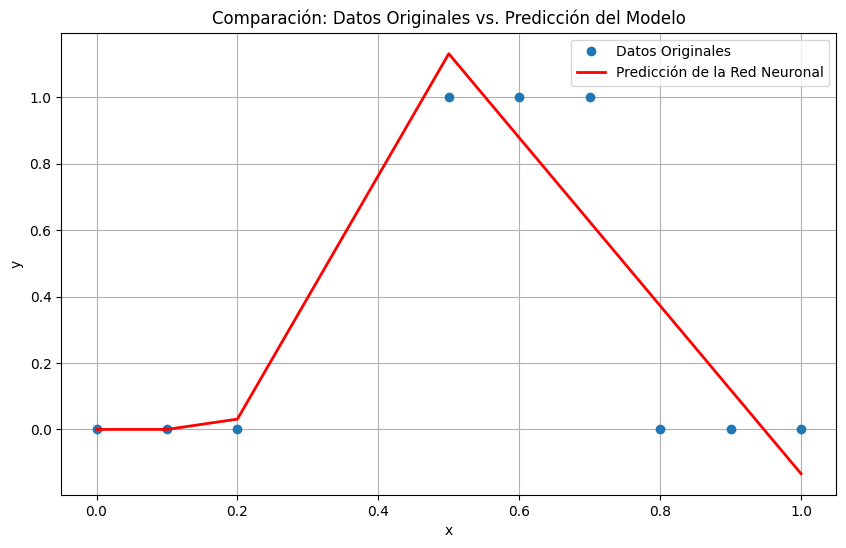

In [19]:
with torch.no_grad():
    y_pred = model(x)

plt.figure(figsize=(10, 6))

# Original data
plt.plot(x.numpy(), y.numpy(), 'o', label='Datos Originales')

sorted_indices = torch.argsort(x.squeeze())
plt.plot(x[sorted_indices].numpy(), y_pred[sorted_indices].numpy(), '-', color='red', linewidth=2, label='Predicción de la Red Neuronal')

plt.title('Comparación: Datos Originales vs. Predicción del Modelo')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()